In [9]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# basic imports
import torch
import timm
import math
import tfimm
import os
import numpy as np
import datetime
import tensorflow as tf 
import tensorflow_addons as tfa
from functools import partial

from keras.utils import dataset_utils
import matplotlib.pyplot as plt

import baseline_config

In [10]:
########################################################################################
# MODEL PARAMETERS
########################################################################################
MODEL_INPUT_IMAGE_WIDTH = 256
MODEL_INPUT_IMAGE_HEIGHT = 256
MODEL_INPUT_IMAGE_CHANNELS = 1

In [11]:
def paths_and_labels_to_dataset(image_paths,labels,num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    img_ds = path_ds.map(
        lambda path: tf.io.read_file(path), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    img_ds = tf.data.Dataset.zip((img_ds, label_ds))
    return img_ds

def create_dataset(subset):
    image_paths, labels, class_names = dataset_utils.index_directory(
            baseline_config.dataset_path + subset,
            labels="inferred",
            formats=('.pt'),
            class_names=None,
            shuffle=False,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=image_paths,
        labels=labels,
        num_classes=len(class_names))
    
    return dataset, class_names

train_dataset, class_names = create_dataset('TRAIN/')
test_dataset, _            = create_dataset('TEST/')
validation_dataset, _      = create_dataset('VALIDATION/')
print("class names: ", class_names)

Found 12384 files belonging to 5 classes.
Found 487 files belonging to 5 classes.
Found 384 files belonging to 5 classes.
class names:  ['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur']


In [12]:
def dataset_transforms(image,label):
  
    # reshape into standard 3 channels
    image = tf.io.parse_tensor(image, tf.float32)
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model expect 3 color channels
    #image = tf.repeat(image, 3, 2)
    
    image = tf.ensure_shape(image, [313, 128, 1])
    image = tf.image.resize(image, (MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH), method=tf.image.ResizeMethod.LANCZOS5)
    
    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+tf.keras.backend.epsilon()) 
    
    return image,label
  
def pre_process_augment_image(image, label, augment_rate):

  p_aug = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  
  if p_aug<augment_rate:
     
    # central crop
    crop_amt = tf.random.uniform([], 0.90, 1.00, dtype=tf.float32)
    image = tf.image.central_crop(image, crop_amt)
    
    # resize back to image size
    image = tf.image.resize(image, (MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH), method=tf.image.ResizeMethod.LANCZOS5)
        
    # Random rotation.
    #angle = tf.random.uniform([], -2.0, 2.0, dtype=tf.float32)
    #image = tfa.image.rotate(image, angle * math.pi / 180.0, interpolation='BILINEAR', fill_mode="nearest")
   
    # Random left-right flip
    image = tf.image.random_flip_left_right(image)
    # Random up-down flip
    #image = tf.image.random_flip_up_down(image) 
    
    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+tf.keras.backend.epsilon())  
    
  return image, label  

In [13]:
np.unique(np.fromiter(test_dataset.map(lambda x, y: tf.argmax(y)), float), return_counts=True) 

(array([0., 1., 2., 3., 4.]), array([142,  62,  65, 124,  94], dtype=int64))

In [14]:
def calculate_target_sampling_rate(dataset):
    vals = np.unique(np.fromiter(dataset.map(lambda x, y: tf.argmax(y)), float), return_counts=True) 
    vals = 1.0 / (vals[1] / len(dataset))
    vals = vals / np.sum(vals)
    return vals

calculate_target_sampling_rate(test_dataset)

array([0.12299007, 0.28168694, 0.268686  , 0.14084347, 0.18579351])

In [15]:
# sample the classes evenly
def make_sampled_dataset(dataset):
    class_name_map = {}
    for index, class_name in enumerate(class_names):
        class_name_map[class_name] = index
    # target_distribution = calculate_target_sampling_rate(dataset) # 
    target_distribution = np.full(len(class_names), 1.0 / len(class_names))

    dataset_classes = [dataset.filter(lambda x,y: tf.argmax(y) == class_index).shuffle(5000).repeat() for class_index in range(len(class_names))]
    sampled_dataset = tf.data.Dataset.sample_from_datasets(dataset_classes, weights=target_distribution)
    return sampled_dataset

train_dataset = make_sampled_dataset(train_dataset)
validation_dataset = make_sampled_dataset(validation_dataset)
test_dataset = make_sampled_dataset(test_dataset)

In [16]:
def test_sampling(dataset):
  bucket_counts = np.zeros(len(class_names))
  for img,label in dataset.take(1000):
    bucket_counts[tf.argmax(label).numpy()] += 1
  print("sample counts :", bucket_counts,
        "final dist    :", bucket_counts / np.sum(bucket_counts))
  
test_sampling(test_dataset)

sample counts : [199. 191. 219. 201. 190.] final dist    : [0.199 0.191 0.219 0.201 0.19 ]


In [17]:
# create all the data pipelines

train_dataset_b = ( 
                  train_dataset       
                  .shuffle(10000)
                  .map(dataset_transforms)                  
                  .cache()
                  #.map(partial(pre_process_augment_image, augment_rate=0.5))
                  .batch(baseline_config.batch_size)
                )

validation_dataset_b = ( 
                  validation_dataset
                  .map(dataset_transforms)
                  .cache()
                  .batch(baseline_config.batch_size)
                )

test_dataset_b = ( 
                  test_dataset
                  .map(dataset_transforms)
                  .cache()
                  .batch(baseline_config.batch_size)
                )

(32, 256, 256, 1) (32, 5)
0.0 1.0
(32, 256, 256, 1) (32, 5)
0.0 1.0
(32, 256, 256, 1) (32, 5)
0.0 1.0


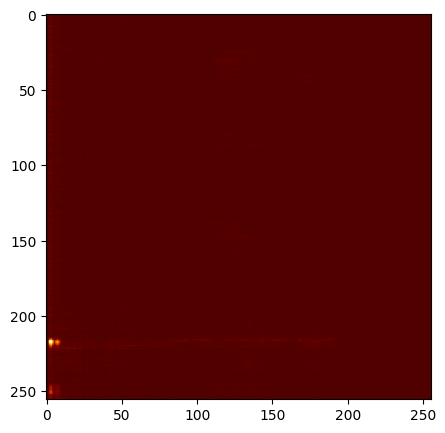

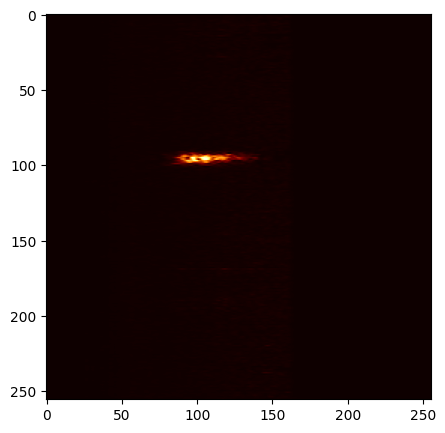

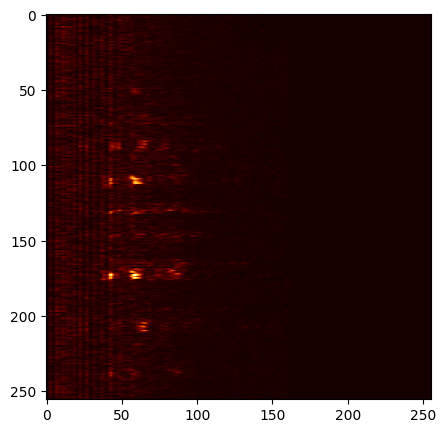

In [18]:
for item,lbl in train_dataset_b.take(3):
    print(item.shape, lbl.shape)
    print(np.min(item), np.max(item))
    plt.figure(figsize=(5,5))
    plt.imshow(item[0,:,:,0], cmap='afmhot')

In [19]:
# uncomment to list all possible timm models
tfimm.list_models()

['cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 '

In [20]:
class CustomTimmModel(tf.keras.Model):
    
    def __init__(self, *args, **kwargs):  
        super(CustomTimmModel, self).__init__(*args, **kwargs)
        self.fm = tfimm.create_model("efficientnet_v2_s_in21k", pretrained=True, in_channels=MODEL_INPUT_IMAGE_CHANNELS)
        
        self.flat = tf.keras.layers.Flatten()
        #self.flat = tf.keras.layers.GlobalMaxPooling2D()
        
        dropout=0.70
        
        self.fc1 = tf.keras.layers.Dense(len(class_names)*20, activation=tf.keras.activations.gelu)
        self.do1 = tf.keras.layers.Dropout(dropout)        
        
        self.fc2 = tf.keras.layers.Dense(len(class_names)*20, activation=tf.keras.activations.gelu)
        self.do2 = tf.keras.layers.Dropout(dropout)
        
        self.fc3 = tf.keras.layers.Dense(len(class_names)*20, activation=tf.keras.activations.gelu)
        self.do3 = tf.keras.layers.Dropout(dropout)        
        
        self.fc4 = tf.keras.layers.Dense(len(class_names)*1, activation=tf.keras.activations.linear)
        

    def call(self, inputs, training=False):
        
        x = self.fm.forward_features(inputs) 
        x = self.flat(x)
        
        x = self.fc1(x)
        x = self.do1(x)
        
        x = self.fc2(x)               
        x = self.do2(x)
        
        x = self.fc3(x)               
        x = self.do3(x)        
        
        x = self.fc4(x)
        
        return x
        
# construct the model
model = CustomTimmModel()

# model.fm.trainable=False

# need to tell the model what the input shape is
model.build([None, MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH, MODEL_INPUT_IMAGE_CHANNELS])

All PyTorch model weights were used when initializing EfficientNet.
All the weights of EfficientNet were initialized from the PyTorch model.



In [22]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.5,
                                                      patience=4, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-8)

# end the training if no improvement for 8 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_timm_model.hdf5', 
                                            save_weights_only=True,
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# fit the model to the training set
history = model.fit(train_dataset_b, 
          steps_per_epoch=100,
          validation_data=validation_dataset_b,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=500)

Epoch 1/500


In [ ]:
# save the model weights
model.save_weights('models/baseline_timm_model.hdf5', save_format='h5')

# test load the model for inference
test_model = CustomTimmModel()
test_model.build([None, MODEL_INPUT_IMAGE_HEIGHT, MODEL_INPUT_IMAGE_WIDTH, MODEL_INPUT_IMAGE_CHANNELS])
test_model.load_weights('models/baseline_timm_model.hdf5')

In [ ]:
def rejection_sampling_experiment():
    import tensorflow as tf
    import numpy as np

    # everything is based on tensorflow 2.0
    tf.random.set_seed(2342)


    def map2label(sample):
        return tf.cast(tf.math.equal(sample, 2), tf.int32)


    np_data = np.array([0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2])
    target_dist = [0.5, 0.5]
    init_dist = [(np_data.shape[0] - 3) / np_data.shape[0], 3 / np_data.shape[0]]

    dataset = tf.data.Dataset.from_tensor_slices(np_data)
    shuffle = tf.data.experimental.shuffle_and_repeat(1, count=1000)
    rej = tf.data.Dataset.rejection_resample(map2label, target_dist, seed=2342)  # set seed explicitly
    dataset = dataset.apply(shuffle).apply(rej)
    dataset = dataset.take(30)

    bucket_counts = [0, 0]
    for i in range(100):
        for data in dataset:
            class_id, data_content = data
            bucket_counts[class_id.numpy()] += 1

    print("This is your target_dist", target_dist, "This is your initial distribution", init_dist)
    print("This is your result counts", bucket_counts,
        "This is your final dist", bucket_counts[0] / np.sum(bucket_counts), bucket_counts[1] / np.sum(bucket_counts))
    
rejection_sampling_experiment()